In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import matplotlib.pyplot as plt
import PIL
from google.colab import drive
import torchsummary
import random
from itertools import product
import numpy as np
rng = np.random.default_rng(12345)
# Load an image
drive.mount('/content/drive')
data_path = '/content/drive/Shareddrives/DeepLearning/Project/Data/'
results_path = '/content/drive/Shareddrives/DeepLearning/Project/Results/'

Mounted at /content/drive


# Mask function
This function simulates the user input

In [2]:
def createMask(img_rgb, points, hor_num_squares=4, ver_num_squares=4):
  c, h, w = img_rgb.shape

  total_squares = hor_num_squares * ver_num_squares
  
  hor_size_square= w // hor_num_squares  # size of the square in the horizontal axis
  ver_size_square= h // ver_num_squares  # size of the square in the vertical axis

  points_per_square = points // total_squares # num puntos por cada cuadrado (16 en total)
  
  # Initializing the mask
  mask = torch.zeros([c, h, w])

  for i in range(0, hor_num_squares):
      for j in range(0,ver_num_squares):
          x_y = [[_x, _y] for (_x, _y) in product(range(i*hor_size_square,hor_size_square*(i+1)), 
                                                  range(j*ver_size_square,ver_size_square*(j+1)))]
          rand_x_y = random.sample(x_y,points_per_square)

          for x, y in rand_x_y:
            # Extract color
            color = img_rgb[:, x, y]
            # Assign color to the mask
            mask[:, x, y] = color

  return mask

# Util functions
## Convert image to range 0 to 1

In [15]:
def imageIn0to1(img):
  min_img = np.min(img)
  max_img = np.max(img)

  rng = max_img - min_img

  return (img - min_img)/rng

def imageIn0to1Torch(img):
  min_img = torch.min(img)
  max_img = torch.max(img)

  rng = max_img - min_img

  return (img - min_img)/rng

# Custom CIFAR10 data loader
It returns a grayscale image, a mask simulating the user painting guidance and the RGB version of the grayscale image

In [ ]:
#Making native class loader
class MyCIFAR10(torchvision.datasets.CIFAR10):
    # Initialization method for the dataset
    def __init__(self,root = data_path + 'CIFAR10', download = False, transform = None, points = 250):
  
        self.transform = transform
        self.points = points

        super().__init__(root, download=download, transform=transform)

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)

        Y_img = img

        BW_img = tf.functional.rgb_to_grayscale(img)

        color_mask = createMask(img, self.points) # mask

        #X_concat = torch.cat([BW_img,mask], dim=0) # concatenation a nivel de color
        # print("BW_img.shape",BW_img.shape)
        # print("mask.shape",mask.shape)
        # print("X_concat.shape",X_concat.shape)
        
        # return the grayscale image, the pseudo-user guidance mask and the original image
        return BW_img, color_mask, Y_img



In [ ]:
''' policies = tf.AutoAugmentPolicy.CIFAR10
tr = tf.Compose([
        tf.AutoAugment(policies),
        tf.ToTensor(), 
        tf.Normalize(mean = [.5], std = [.5])
        ])

user_points=256
custom_cf10_data = MyCIFAR10(data_path + 'CIFAR10', download=True, transform=tr,points=user_points)
batch_size=64
custom_data_loader = torch.utils.data.DataLoader(custom_cf10_data,
                                          batch_size=batch_size,
                                          shuffle=True) '''

" policies = tf.AutoAugmentPolicy.CIFAR10\ntr = tf.Compose([\n        tf.AutoAugment(policies),\n        tf.ToTensor(), \n        tf.Normalize(mean = [.5], std = [.5])\n        ])\n\nuser_points=256\ncustom_cf10_data = MyCIFAR10(data_path + 'CIFAR10', download=True, transform=tr,points=user_points)\nbatch_size=64\ncustom_data_loader = torch.utils.data.DataLoader(custom_cf10_data,\n                                          batch_size=batch_size,\n                                          shuffle=True) "

# Custom STL10 data loader
It returns a grayscale image, a mask simulating the user painting guidance and the RGB version of the grayscale image

In [4]:
import random
from itertools import product
# Custom STL10 Dataset: https://cs.stanford.edu/~acoates/stl10/
class MySTL10(torchvision.datasets.STL10):
    # Initialization method for the dataset
    def __init__(self, root = data_path + 'STL10', split = 'train', 
                 download = False, transform = None, points = 250):

        self.points = points
        self.norm = tf.Normalize(mean = [.5], std = [.5])
        super().__init__(root, split = split, download=download, transform=transform)


    def __getitem__(self, index):
        img, _ = super().__getitem__(index)

        Y_img = img
        
        BW_img = tf.functional.rgb_to_grayscale(img)

        color_mask = createMask(img, self.points) # mask

        # Normalizing. We do it here because we need that the mask gets the values from the unnormalized image 
        Y_img = self.norm.forward(Y_img) 
        BW_img = self.norm.forward(BW_img)
        color_mask = self.norm.forward(color_mask)

        #X_concat = torch.cat([BW_img,mask], dim=0) # concatenation a nivel de color
        # print("BW_img.shape",BW_img.shape)
        # print("mask.shape",mask.shape)
        # print("X_concat.shape",X_concat.shape)
        
        # return the grayscale image, the pseudo-user guidance mask and the original image
        return BW_img, color_mask, Y_img


In [ ]:
''' random_tf_1 = [tf.GaussianBlur(kernel_size=(3,3), sigma = (0.1, 0.1)),
              tf.RandomHorizontalFlip(p = 0.5),
              tf.RandomVerticalFlip(p = 0.5)] '''

random_tf_2 = [tf.RandomAdjustSharpness(sharpness_factor = 1.5),
               tf.RandomHorizontalFlip(p = 0.5),
               tf.RandomVerticalFlip(p = 0.5)]

tr = tf.Compose([
        tf.ToTensor(), 
        #tf.Normalize(mean = [.5], std = [.5])
        #tf.RandomApply(random_tf_1, p = 0.5),
        tf.RandomApply(random_tf_2, p = 0.5),
        ])
#minimum 3 point per square and maximum 15

user_points=rng.integers(low=50, high=100, size=1) #generates points around 50 and 100
user_points=user_points[0]
print('User points:',user_points)
custom_stl_10_data = MySTL10(root = data_path + 'STL10', split = 'train', 
                 download = True, transform = tr, points = user_points)
batch_size=64

train_dataloader_stl_10 = torch.utils.data.DataLoader(custom_stl_10_data,
                                          batch_size=batch_size,
                                          shuffle=True)

User points: 60


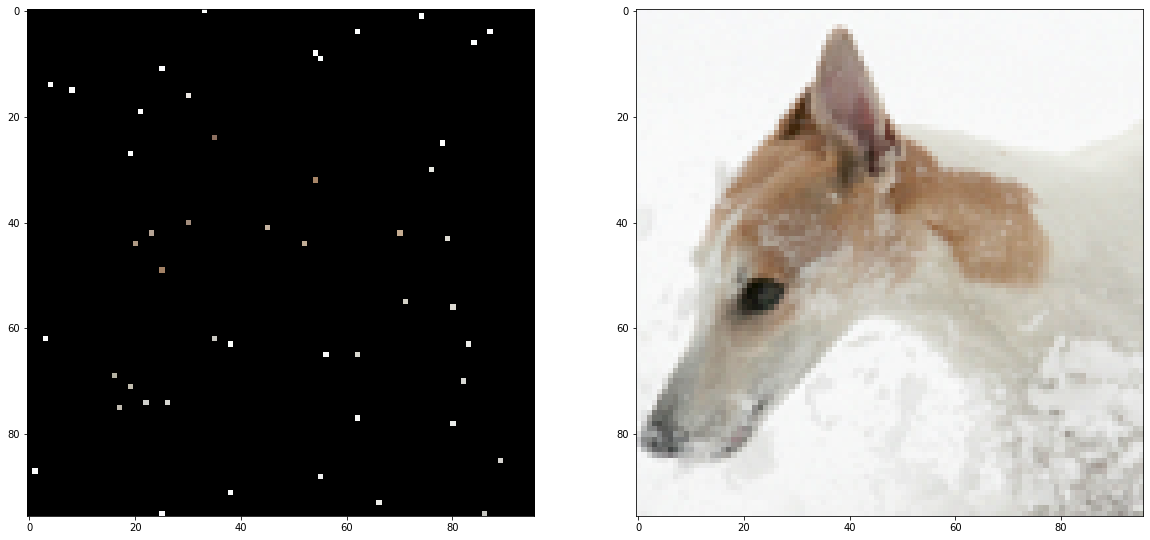

In [ ]:
BW_img, color_mask, Y_img = next(iter(train_dataloader_stl_10))
plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(imageIn0to1(color_mask[0].permute(1,2,0).squeeze().numpy()))
plt.subplot(1,2,2)
plt.imshow(imageIn0to1(Y_img[0].permute(1,2,0).squeeze().numpy()))
plt.show()


# Implementing Generator for conditional GAN
This is based on the [paper](https://onlinelibrary.wiley.com/doi/full/10.1002/int.22726?casa_token=hYkYZaiJzQwAAAAA%3AtO40_a1tNp9nkdVI6ljm2USOwFJHl13oHZwu7BZ6XcMpIvPCjEnaQzDC6aiPdK7rmoCYVheTEH3tlH4).

Since our images are 32x32x3 images, then our implementation would be:
* 2 downsampling layers (3 in original)
* 9 residual blocks (9 in original)
* 2 upsampling layers (3 in original)

All layers are added with batch normalization and the activation function is ReLU, except for the last layer where the activation function is TanH.

Also, it is important noting that the paper uses CIE Lab color space, which has 3 channels:
* $L$ = Luminance
* $a$= coordenadas rojo/verde (+a indica rojo, -a indica verde)
* $b$ = coordenadas amarillo/azul (+b indica amarillo, -b indica azul)

Then, for them, the generator objective is predicting the values of channels $a$ and $b$ given the channel $L$ and the mask as input. So, their fake image is the concatenation of [L, a, b]. 

However, we will not be using this color space, but the RGB color space. Then, the generator objective is obtaining and RGB colored image from the grayscale image and the mask. This output is our fake image (we do not need to concatenate anything)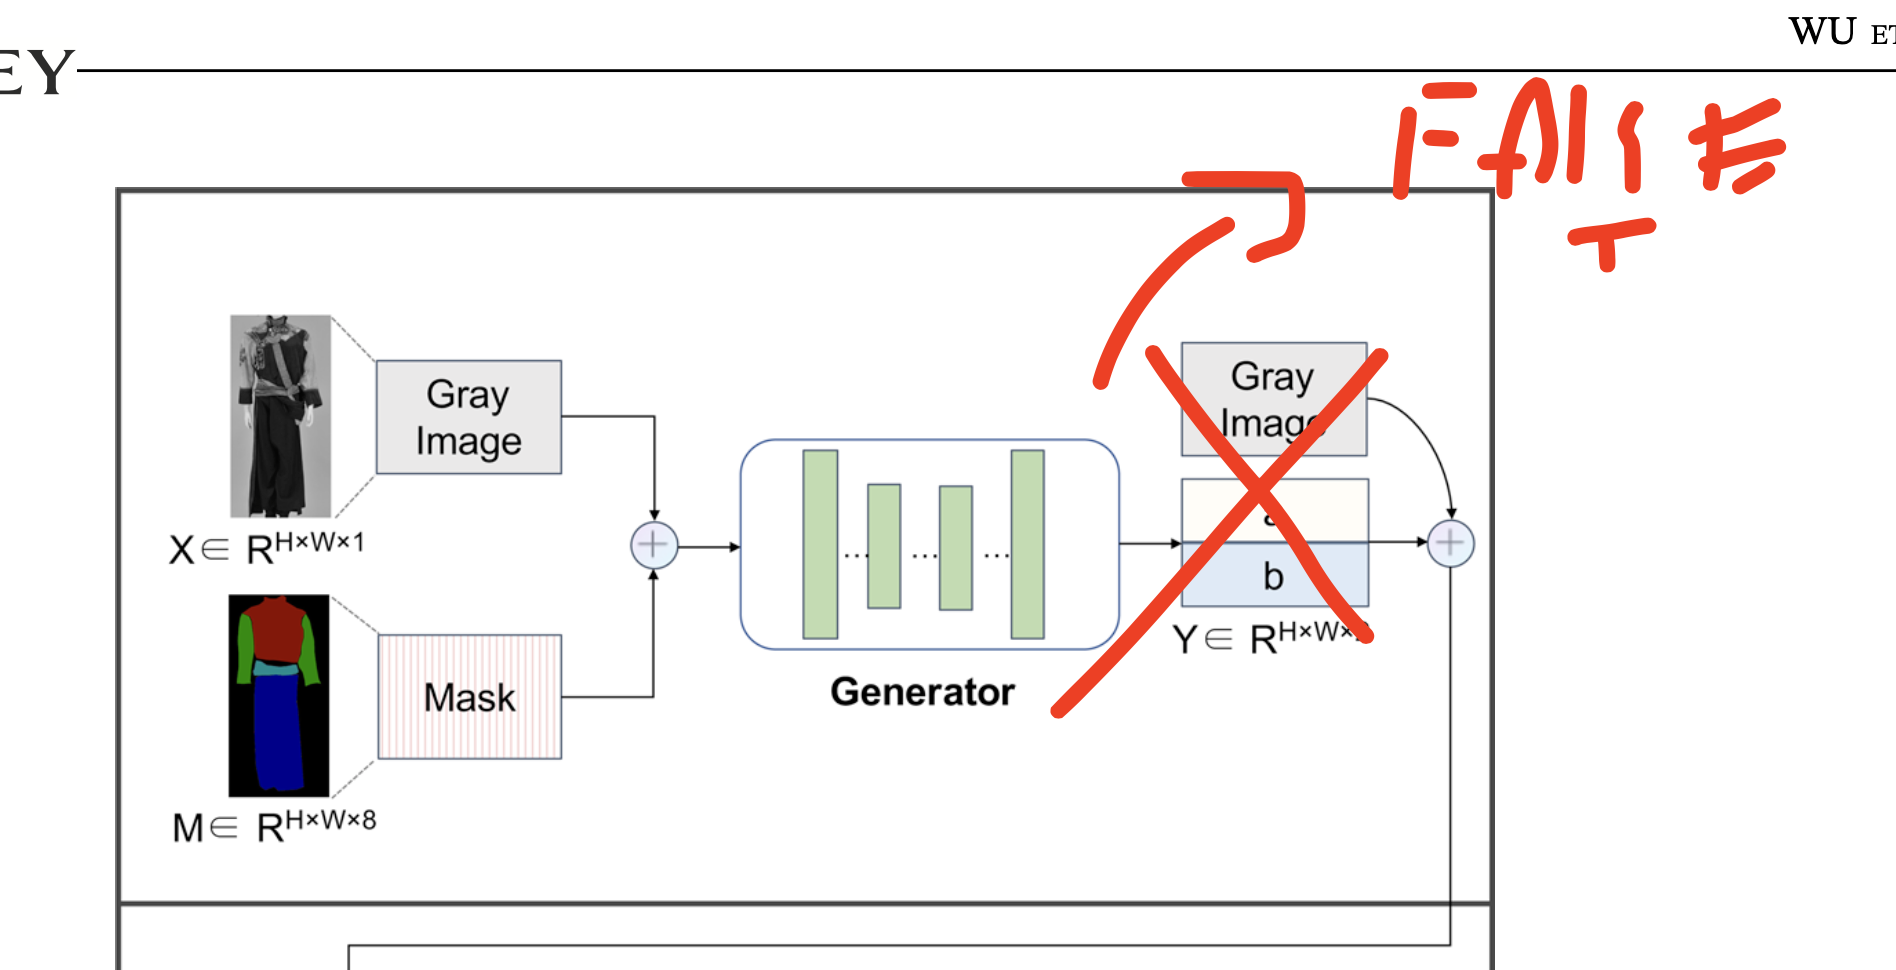

In [5]:
# Convolution + BatchNormnalization + ReLU or Tanh block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, activation: str = "relu"):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)

    if activation.lower() == "relu":
      self.activation = nn.ReLU(inplace=True)
    elif activation.lower() == "tanh":
      self.activation = nn.Tanh()
    else:
      raise Exception("Activations available are: relu or tanh")

  def forward(self,x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.activation(out)   
    return out


# Downsampling Convolution + BatchNormnalization + ReLU block for the encoder
class DownsamplinConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(DownsamplinConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          stride= 2, padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self,x):
    out = self.conv(x)
    out = self.bn(out)
    out = self.relu(out)   
    return out

# Upsampling Convolution (Deconvolution) + BatchNormnalization + ReLU block for the encoder
class UpsamplinConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels):
    super(UpsamplinConvBNReLU, self).__init__()
    self.deconv = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=3,
                          stride= 2, padding = 1, output_padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

  def forward(self,x):
    out = self.deconv(x)
    out = self.bn(out)
    out = self.relu(out)   
    return out


# Residual blocks + BatchNormnalization + ReLU block for the encoder
# it keeps the same number of channels
class ResidualBlockBNReLU(nn.Module):
  def __init__(self,channels):
    super(ResidualBlockBNReLU, self).__init__()

    self.conv1 = ConvBNReLU(channels, channels, activation = "relu")
    self.conv2 = ConvBNReLU(channels, channels, activation = "relu")

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = out + x # Residual connection
    return out 

In [6]:
class Generator(nn.Module):
  def __init__(self, img_channels = 4, base_channels=64, out_channels = 3):
    super(Generator, self).__init__()
    #self.base_channels = base_channels
    #self.in_features = img_channels
    #self.decoder = Decoder(in_features,base_channels)
    # First convolutional block
    self.first_conv = ConvBNReLU(img_channels, base_channels)

    # Downsampling blocks
    self.down_conv1 = DownsamplinConvBNReLU(base_channels, base_channels*2)
    self.down_conv2 = DownsamplinConvBNReLU(base_channels*2, base_channels*4)

    # Residual blocks
    self.res_block1 = ResidualBlockBNReLU(base_channels*4)
    self.res_block2 = ResidualBlockBNReLU(base_channels*4)
    self.res_block3 = ResidualBlockBNReLU(base_channels*4)
    self.res_block4 = ResidualBlockBNReLU(base_channels*4)
    self.res_block5 = ResidualBlockBNReLU(base_channels*4)
    self.res_block6 = ResidualBlockBNReLU(base_channels*4)
    self.res_block7 = ResidualBlockBNReLU(base_channels*4)
    self.res_block8 = ResidualBlockBNReLU(base_channels*4)
    self.res_block9 = ResidualBlockBNReLU(base_channels*4) 

    # Upsampling blocks
    self.up_conv1 = UpsamplinConvBNReLU(base_channels*4, base_channels*2)
    self.up_conv2 = UpsamplinConvBNReLU(base_channels*2, base_channels)

    # Last 
    self.last_conv = ConvBNReLU(base_channels, out_channels, activation = "tanh")

  def forward(self, x):
    out = self.first_conv(x)

    # Downsampling
    out = self.down_conv1(out)
    out = self.down_conv2(out)

    # Residual blocks
    out = self.res_block1(out)
    out = self.res_block2(out)
    out = self.res_block3(out)
    out = self.res_block4(out)
    out = self.res_block5(out)
    out = self.res_block6(out)
    out = self.res_block7(out)
    out = self.res_block8(out)
    out = self.res_block9(out)

    # Upsampling blocks
    out = self.up_conv1(out)
    out = self.up_conv2(out)

    # Last conv
    out = self.last_conv(out)

    return out

In [ ]:
generator = Generator(img_channels = 4, base_channels = 64, out_channels = 3)
generator = generator.cuda()

torchsummary.summary(generator, input_size=(4, 92, 92))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 92, 92]           2,368
       BatchNorm2d-2           [-1, 64, 92, 92]             128
              ReLU-3           [-1, 64, 92, 92]               0
        ConvBNReLU-4           [-1, 64, 92, 92]               0
            Conv2d-5          [-1, 128, 46, 46]          73,856
       BatchNorm2d-6          [-1, 128, 46, 46]             256
              ReLU-7          [-1, 128, 46, 46]               0
DownsamplinConvBNReLU-8          [-1, 128, 46, 46]               0
            Conv2d-9          [-1, 256, 23, 23]         295,168
      BatchNorm2d-10          [-1, 256, 23, 23]             512
             ReLU-11          [-1, 256, 23, 23]               0
DownsamplinConvBNReLU-12          [-1, 256, 23, 23]               0
           Conv2d-13          [-1, 256, 23, 23]         590,080
      BatchNorm2d-14          [-

# Implementing Discriminator for conditional GAN
For the discriminator, we still be using the methodology proposed in the previous paper.

In this case, they use a multiscale discriminator along with PatchGan. In particular, a two-scale discriminator.
The PatchGan is a method to obtain different discriminator results in chunks. Originally, it was used to make like a patch-wise discriminator in a in image. That is, classifying the image by patches. So the output was a NxN matrix where each value was the classification of a patch.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, input_channels = 6, base_channels=64):
    super(Discriminator, self).__init__()
       
    # First Downsampling blocks
    self.conv1_1 = ConvBNReLU(input_channels, base_channels)
    self.down_conv1_1 = DownsamplinConvBNReLU(base_channels, base_channels*2)
    self.down_conv1_2 = DownsamplinConvBNReLU(base_channels*2, base_channels*4)
    self.down_conv1_3 = DownsamplinConvBNReLU(base_channels*4, base_channels*8)

    # Mean pool for multiscale discrimination
    self.av_pool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    # Second Downsampling blocks
    self.conv2_1 = ConvBNReLU(input_channels, base_channels)
    self.down_conv2_1 = DownsamplinConvBNReLU(base_channels, base_channels*2)
    self.down_conv2_2 = DownsamplinConvBNReLU(base_channels*2, base_channels*4)
    self.down_conv2_3 = DownsamplinConvBNReLU(base_channels*4, base_channels*8)

    # Sigmoid function for the final output
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # First scale discriminator
    out_disc_1_conv = self.conv1_1(x)
    # Downsampling of the first discriminator
    out_disc_1 = self.down_conv1_1(out_disc_1_conv)
    out_disc_1 = self.down_conv1_2(out_disc_1)
    out_disc_1 = self.down_conv1_3(out_disc_1)
    out_disc_1 = torch.mean(out_disc_1, dim=[1,2,3])

    # Second scale discriminator
    out_down = self.av_pool(x) # Mean Pooling Downsampling
    # Downsampling of the second discriminator
    out_disc_2_conv = self.conv2_1(out_down)
    out_disc_2 = self.down_conv2_1(out_disc_2_conv)
    out_disc_2 = self.down_conv2_2(out_disc_2)
    out_disc_2 = self.down_conv2_3(out_disc_2) 
    out_disc_2 = torch.mean(out_disc_2, dim=[1,2,3])

    out = out_disc_1 + out_disc_2
    out = self.sigmoid(out)

    return out

In [ ]:
discriminator = Discriminator(input_channels=6,  base_channels=64)
discriminator = discriminator.cuda()
torchsummary.summary(discriminator, input_size=(6, 92, 92))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 92, 92]           3,520
       BatchNorm2d-2           [-1, 64, 92, 92]             128
              ReLU-3           [-1, 64, 92, 92]               0
        ConvBNReLU-4           [-1, 64, 92, 92]               0
            Conv2d-5          [-1, 128, 46, 46]          73,856
       BatchNorm2d-6          [-1, 128, 46, 46]             256
              ReLU-7          [-1, 128, 46, 46]               0
DownsamplinConvBNReLU-8          [-1, 128, 46, 46]               0
            Conv2d-9          [-1, 256, 23, 23]         295,168
      BatchNorm2d-10          [-1, 256, 23, 23]             512
             ReLU-11          [-1, 256, 23, 23]               0
DownsamplinConvBNReLU-12          [-1, 256, 23, 23]               0
           Conv2d-13          [-1, 512, 12, 12]       1,180,160
      BatchNorm2d-14          [-

# Train function
We have followed this workflow:

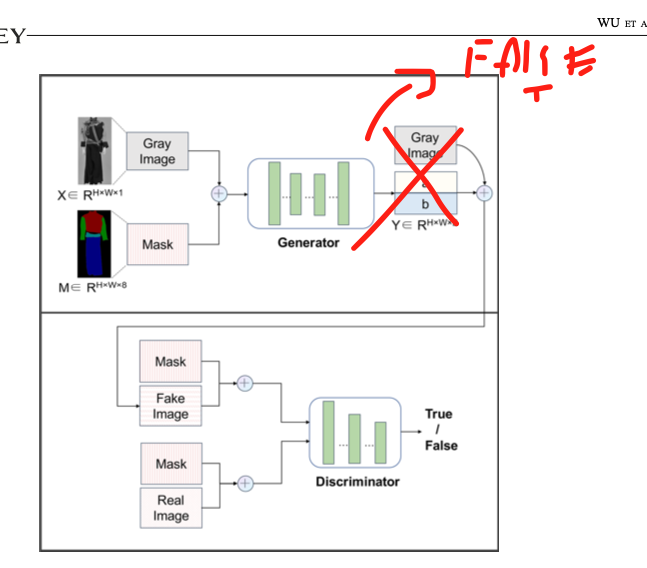

Regarding the loss, the proposed one was this 
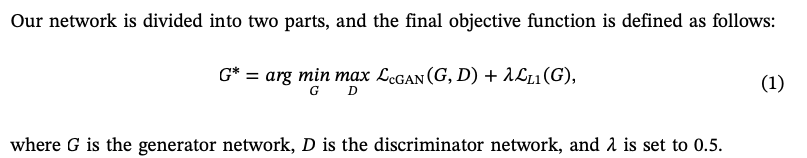

However, we are still working on undeerstanding it... So, for now, we are using the loss that the teachers proposed in the examples of Lab 4. 

I think that we only need to add the L1 norm to the Loss generator to follow the loss proposed in the image.

In [ ]:
# GAN Train function. We have a generator and discriminator models and their respective optimizers.
def train_GAN(gen, disc,  train_loader, optimizer_gen, optim_disc,
              num_epochs=10, model_name='gan_mnist.ckpt', device='cpu', lbmda = 0.5):
    gen = gen.to(device)
    gen.train() # Set the generator in train mode
    disc = disc.to(device)
    disc.train() # Set the discriminator in train mode

    total_step = len(train_loader)
    losses_list = []

    l1_loss = nn.L1Loss()

    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        disc_loss_avg = 0
        gen_loss_avg = 0
        nBatches = 0
        update_generator = True

        for i, (BW_img, color_mask, Y_img) in enumerate(train_loader):
            # Get batch of samples and labels
            BW_imges = BW_img.to(device)

            color_masks = color_mask.to(device)
            
            Y_imges = Y_img.to(device) # verificar con el discri
            
            # Forward pass
            # Generate random images with the generator
            BW_img_and_mask = torch.concat([BW_imges, color_masks], dim=1)
            fake_images = gen.forward(BW_img_and_mask)
            
            # Concatenate the Fake image with the mask
            fake_images_and_mask = torch.concat([fake_images, color_masks], dim=1)

            # Concatenate the original image with the mask
            Y_img_and_mask = torch.concat([Y_imges, color_masks], dim=1)
            
            # Use the discriminator to obtain the probabilties for real and generate imee
            prob_fake = disc.forward(fake_images_and_mask)
            prob_real = disc.forward(Y_img_and_mask)
            
            # Generator loss
            cur_l1_loss = lbmda * l1_loss(fake_images, Y_imges)

            #gen_loss = -torch.log(prob_fake).mean() + lbmda*(fake_images_and_mask - Y_imges) # Esto proponen en el paper, pero no sé muy bien como implementarlo
            gen_loss = -torch.log(prob_fake).mean() + cur_l1_loss
            # Discriminator loss
            disc_loss = -0.5*(torch.log(prob_real) + torch.log(1-prob_fake)).mean()

            
            # We are going to update the discriminator and generator parameters alternatively at each iteration

            if(update_generator):
              # Optimize generator
              # Backward and optimize
              optimizer_gen.zero_grad()
              gen_loss.backward() # Necessary to not erase intermediate variables needed for computing disc_loss gradient
              optimizer_gen.step()
              update_generator = False
            else:           
              # Optimize discriminator
              # Backward and optimize
              optimizer_disc.zero_grad()
              disc_loss.backward()
              optimizer_disc.step()
              update_generator = True
                

            disc_loss_avg += disc_loss.cpu().item()
            gen_loss_avg += gen_loss.cpu().item()

            nBatches+=1
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Gen. Loss: {:.4f}, Disc Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, gen_loss_avg / nBatches, disc_loss_avg / nBatches))
        # Save model
        losses_list.append(disc_loss_avg / nBatches)
        torch.save(gan_gen.state_dict(), results_path+ '/' + model_name)
          
    return losses_list 

## Training

In [ ]:
# Define Geneartor and Discriminator networks
gan_gen = Generator(img_channels = 4, base_channels = 64, out_channels = 3)
gan_disc = Discriminator(input_channels=6,  base_channels=64)

#Initialize indepdent optimizer for both networks
learning_rate = .0005
optimizer_gen = torch.optim.Adam(gan_gen.parameters(),lr = learning_rate, weight_decay=1e-5)
optimizer_disc = torch.optim.Adam(gan_disc.parameters(),lr = learning_rate, weight_decay=1e-5)
num_epochs = 100

# Train the GAN
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_list = train_GAN(gan_gen,gan_disc, train_dataloader_stl_10, optimizer_gen, optimizer_disc,
                      num_epochs=num_epochs, model_name='cgan_stl_10.ckpt', device=device)

Epoch [1/100], Step [79/79], Gen. Loss: 0.5730, Disc Loss: 0.7165
Epoch [2/100], Step [79/79], Gen. Loss: 0.5769, Disc Loss: 0.7070
Epoch [3/100], Step [79/79], Gen. Loss: 0.5690, Disc Loss: 0.7132
Epoch [4/100], Step [79/79], Gen. Loss: 0.5615, Disc Loss: 0.7236
Epoch [5/100], Step [79/79], Gen. Loss: 0.5761, Disc Loss: 0.7246
Epoch [6/100], Step [79/79], Gen. Loss: 0.6001, Disc Loss: 0.7157
Epoch [7/100], Step [79/79], Gen. Loss: 0.6144, Disc Loss: 0.7100
Epoch [8/100], Step [79/79], Gen. Loss: 0.6164, Disc Loss: 0.7124
Epoch [9/100], Step [79/79], Gen. Loss: 0.6334, Disc Loss: 0.6983
Epoch [10/100], Step [79/79], Gen. Loss: 0.6392, Disc Loss: 0.6987
Epoch [11/100], Step [79/79], Gen. Loss: 0.6449, Disc Loss: 0.7077
Epoch [12/100], Step [79/79], Gen. Loss: 0.6485, Disc Loss: 0.7018
Epoch [13/100], Step [79/79], Gen. Loss: 0.6501, Disc Loss: 0.7042
Epoch [14/100], Step [79/79], Gen. Loss: 0.6612, Disc Loss: 0.7016
Epoch [15/100], Step [79/79], Gen. Loss: 0.6543, Disc Loss: 0.7033
Epoc

# Testing

In [7]:
tr = tf.Compose([
        tf.ToTensor()#, 
        #tf.Normalize(mean = [.5], std = [.5])
        ])

user_points=250
custom_stl_10_data_test = MySTL10(root = data_path + 'STL10', split = 'test', 
                 download = True, transform = tr, points = user_points)
batch_size=64

test_dataloader_stl_10 = torch.utils.data.DataLoader(custom_stl_10_data_test,
                                          batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [8]:
# Load generator
gan_gen = Generator(img_channels = 4, base_channels = 64, out_channels = 3)
gan_gen.load_state_dict(torch.load(results_path+'cgan_stl_10_100ep_60pts.ckpt'))
gan_gen.eval() # Put in eval model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gan_gen = gan_gen.to(device)

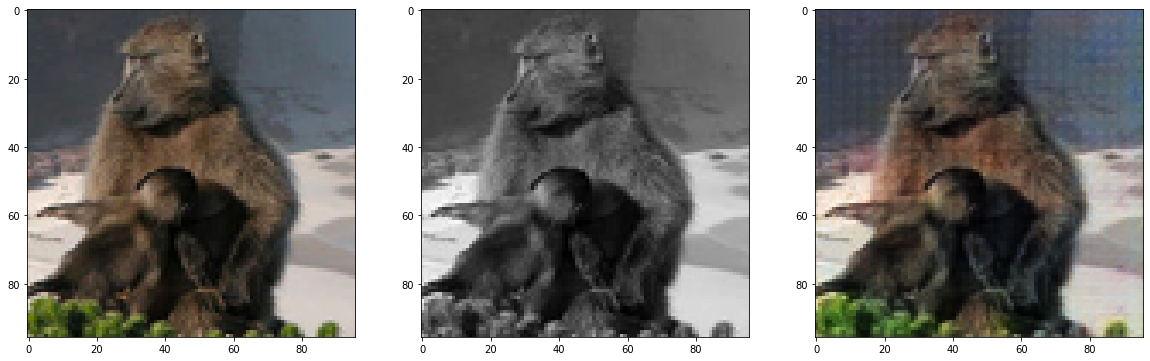

In [9]:
BW_img, color_mask, Y_img = next(iter(test_dataloader_stl_10))
BW_img = BW_img[0]
color_mask = color_mask[0]
Y_img = Y_img[0]
''' print(BW_img.shape)
print(color_mask.shape)
print(Y_img.shape) '''
BW_img_and_mask = torch.concat([BW_img, color_mask], dim=0).unsqueeze(0)
#print(BW_img_and_mask.shape)

fake_img = gan_gen.forward(BW_img_and_mask.to(device))

# Generate random images from sampled vectors z and visualize them 
plt.figure(figsize=(20,15))

plt.subplot(1,3,1)
Y_img = Y_img.permute(1,2,0).detach().numpy()
Y_img = imageIn0to1(Y_img)
plt.imshow(Y_img)

plt.subplot(1,3,2)
BW_img = BW_img.squeeze().detach().numpy()
BW_img_3_chn = np.array([BW_img, BW_img, BW_img])
BW_img_3_chn = np.moveaxis(BW_img_3_chn, 0, -1)
BW_img_3_chn = imageIn0to1(BW_img_3_chn)
plt.imshow(BW_img_3_chn)

plt.subplot(1,3,3)
fake_img = fake_img.squeeze().permute(1,2,0).detach().cpu().numpy()
fake_img = imageIn0to1(fake_img)
plt.imshow(fake_img)

plt.show()

In [10]:
ig=rng.integers(low=1, high=20, size=1) #generates points around 50 and 100
ig=ig[0]

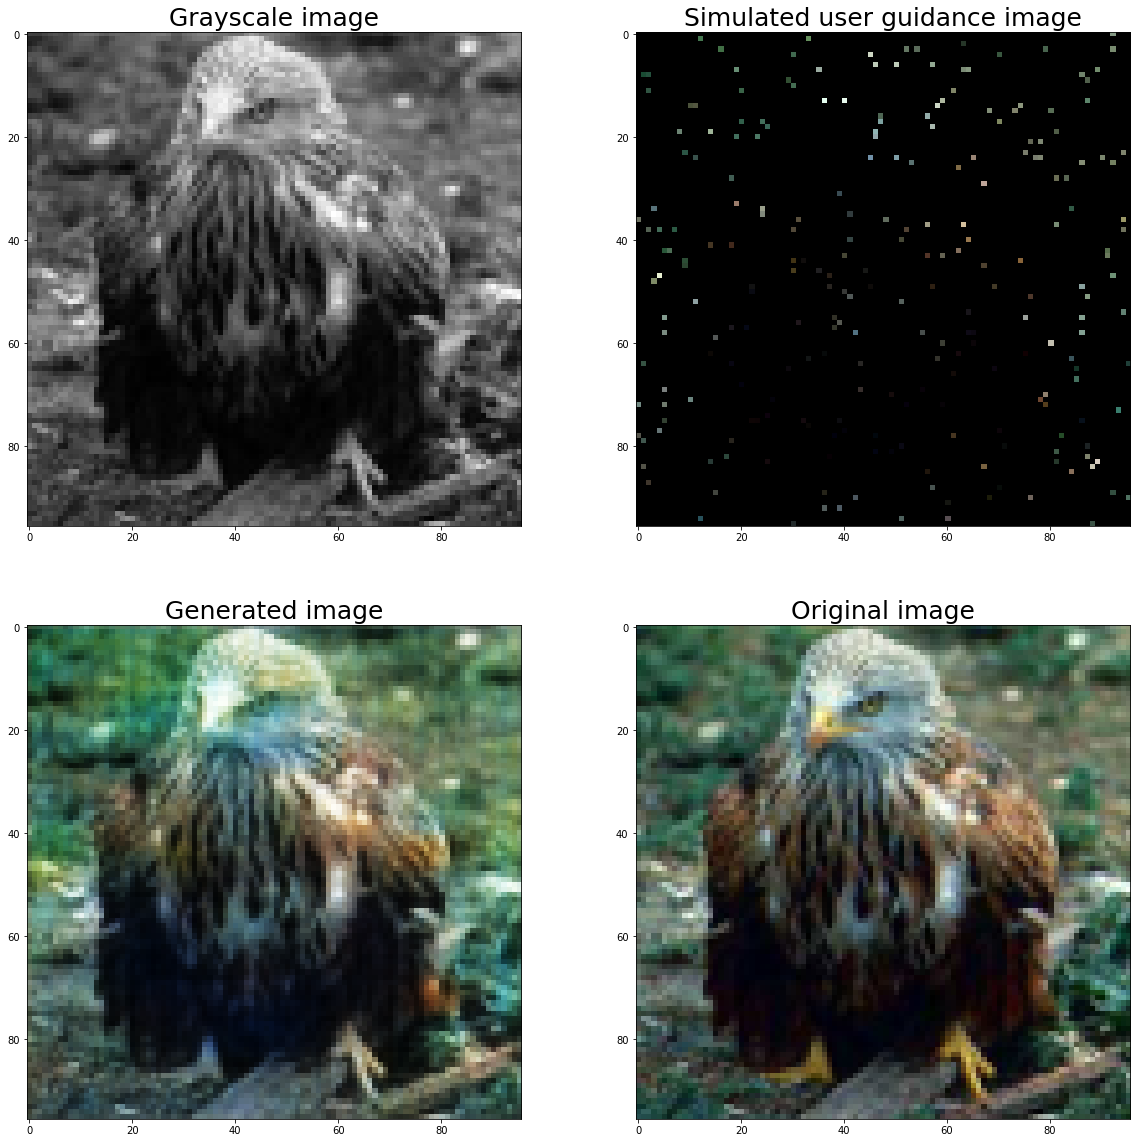

In [11]:

BW_img, color_mask, Y_img = custom_stl_10_data_test[ig]
''' print(BW_img.shape)
print(color_mask.shape)
print(Y_img.shape) '''
BW_img_and_mask = torch.concat([BW_img, color_mask], dim=0).unsqueeze(0)
#print(BW_img_and_mask.shape)

# Load generator
gan_gen = Generator(img_channels = 4, base_channels = 64, out_channels = 3)
gan_gen.load_state_dict(torch.load(results_path+'cgan_stl_10_100ep_60pts.ckpt'))
gan_gen.eval() # Put in eval model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gan_gen = gan_gen.to(device)

fake_img = gan_gen.forward(BW_img_and_mask.to(device))

# Generate random images from sampled vectors z and visualize them 
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
BW_img = BW_img.squeeze().detach().numpy()
BW_img_3_chn = np.array([BW_img, BW_img, BW_img])
BW_img_3_chn = np.moveaxis(BW_img_3_chn, 0, -1)
BW_img_3_chn = imageIn0to1(BW_img_3_chn)
plt.imshow(BW_img_3_chn)
plt.title("Grayscale image", size=25)

plt.subplot(2,2,2)
color_mask = color_mask.squeeze().permute(1,2,0).detach().cpu().numpy()
color_mask = imageIn0to1(color_mask)
plt.imshow(color_mask)
plt.title("Simulated user guidance image", size=25)

plt.subplot(2,2,3)
fake_img = fake_img.squeeze().permute(1,2,0).detach().cpu().numpy()
fake_img = imageIn0to1(fake_img)
plt.imshow(fake_img)
plt.title("Generated image", size=25)

plt.subplot(2,2,4)
Y_img = Y_img.permute(1,2,0).detach().numpy()
Y_img = imageIn0to1(Y_img)
plt.imshow(Y_img)
plt.title("Original image", size=25)

plt.show()

In [12]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 4.9 MB/s 


In [13]:
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

In [16]:
history_mse = []
history_psnr = []
history_ssim = []

mse = nn.MSELoss()

psnr = PSNR(data_range=1.0)
psnr.attach(default_evaluator, 'psnr')

metric = SSIM(data_range=1.0)
metric.attach(default_evaluator, 'ssim')

with torch.no_grad():

  for i, (BW_img, color_mask, Y_img) in enumerate(test_dataloader_stl_10):
    # Get batch of samples and labels
    BW_imges = BW_img.to(device)

    color_masks = color_mask.to(device)
    
    Y_imges = Y_img.to(device) # verificar con el discri
    
    # Forward pass
    # Generate random images with the generator
    BW_img_and_mask = torch.concat([BW_imges, color_masks], dim=1)
    fake_images = gan_gen.forward(BW_img_and_mask)

    for j in range(0, len(Y_imges)):
      fake_images[j,:,:,:] = imageIn0to1Torch(fake_images[j,:,:,:])
      Y_imges[j,:,:,:] = imageIn0to1Torch(Y_imges[j,:,:,:])

    # MSE compute
    mse_value = mse(fake_images, Y_imges).cpu().numpy()
    history_mse.append(mse_value)

    state = default_evaluator.run([[fake_images, Y_imges]])
    
    # PSNR compute
    psnr_value = state.metrics['psnr']
    history_psnr.append(psnr_value)

    # SSIM compute
    ssim_value = state.metrics['ssim']
    history_ssim.append(ssim_value)

mse_mean = np.mean(history_mse)
psnr_mean = np.mean(history_psnr)
ssim_mean = np.mean(history_ssim)

print(f"Mean MSE: {mse_mean}")
print(f"Mean PSNR: {psnr_mean}")
print(f"Mean SSIM: {ssim_mean}")

Mean MSE: 0.005481706000864506
Mean PSNR: 23.742900126828648
Mean SSIM: 0.8436279974996509
